<a href="https://colab.research.google.com/github/jacmal/CRYPTO-Returns-Strategy-Analysis/blob/main/CRYPTO_Price_Retruns_Trend_Strategy_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES

In [ ]:
import os
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import json
import requests
import io

from collections import deque
from datetime import datetime
from scipy.optimize import brute

In [ ]:
#plt.style.use('seaborn')
plt.style.use('dark_background')
#plt.style.use('fivethirtyeight')
#plt.style.use('seaborn-dark-palette')
#plt.style.use('seaborn-dark')
#plt.style.use('seaborn-darkgrid')

# LOAD DATASET

In [ ]:
# TODO !!!

# Crypto Datasets URLS
# Daily prices datasets
url_btc_d = 'https://raw.githubusercontent.com/jacmal/CRYPTO-Returns-Strategy-Analysis/main/datasets/BTC-USD_daily.csv'
url_eth_d = 'https://raw.githubusercontent.com/jacmal/CRYPTO-Returns-Strategy-Analysis/main/datasets/ETH-USD_daily.csv'
url_bnb_d = 'https://raw.githubusercontent.com/jacmal/CRYPTO-Returns-Strategy-Analysis/main/datasets/BNB-USD_daily.csv'
# Hourly prices datasets
url_btc_h = 'https://raw.githubusercontent.com/jacmal/CRYPTO-Returns-Strategy-Analysis/main/datasets/Binance_BTCUSDT_1h.csv'
url_eth_h = 'https://raw.githubusercontent.com/jacmal/CRYPTO-Returns-Strategy-Analysis/main/datasets/Binance_ETHUSDT_1h.csv'
url_bnb_h = 'https://raw.githubusercontent.com/jacmal/CRYPTO-Returns-Strategy-Analysis/main/datasets/Binance_BNBUSDT_1h.csv'

# DEV load data sets
#url_btc = "https://raw.githubusercontent.com/jacmal/crypto/main/data_sets/Binance_BTCUSDT_1h.csv"
#url_eth = "https://raw.githubusercontent.com/jacmal/crypto/main/data_sets/Binance_ETHUSDT_1h.csv"
##url_bnb = "https://raw.githubusercontent.com/jacmal/crypto/main/data_sets/Binance_BNBUSDT_1h.csv"

site_btc = requests.get(url_btc_d).content
#site_eth = requests.get(url_eth_d).content

df_btc = pd.read_csv(io.StringIO(site_btc.decode('utf-8')))
#df_eth = pd.read_csv(io.StringIO(site_eth.decode('utf-8')))

# reverse data sets
#df_btc = df_btc.loc[::-1].reset_index(drop=True)
#df_btc = df_btc.iloc[1:,:]

#df_eth = df_eth.loc[::-1].reset_index(drop=True)
#df_eth = df_eth.iloc[1:,:]

#
#col_to_drop = ['unix', 'symbol', 'Volume USDT', 'tradecount', 'Volume BTC']

#df_btc.drop(labels=col_to_drop, axis=1, inplace=True)
#df_eth.drop(labels=col_to_drop, axis=1, inplace=True)

#df_btc.set_index('date', drop=True, inplace=True)
#df_eth.set_index('date', drop=True, inplace=True)

#df_btc['Open_btc'] = df_btc['open'].copy()

df_btc.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700


,Date,Open,High,Low,Close,Adj Close,Volume
2791,2022-05-09,34060.015625,34222.074219,30296.953125,30296.953125,30296.953125,63355494961
2792,2022-05-10,30273.654297,32596.308594,29944.802734,31022.906250,31022.906250,59811038817
2793,2022-05-11,31016.183594,32013.402344,28170.414063,28936.355469,28936.355469,70388855818
2794,2022-05-12,28936.734375,30032.439453,26350.490234,29047.751953,29047.751953,66989173272
2795,2022-05-13,28971.544922,30919.562500,28786.167969,29633.236328,29633.236328,43801907200


In [ ]:
df = df_btc[['Date', 'Close']].copy()

# FINANCIAL DATA PREPROCESSING and FEATURES ENGINEERING

## DEV Test new features

In [ ]:
# TODO !!!

PRICE = 'close'
df_f = df_btc[['Date', PRICE]].copy()

# SIMPLE TRADING TECHNICAL INDICATORS
df_f['diff'] = df_f[PRICE] - df_f[PRICE].shift(1)
df_f['diff_%'] = (df_f[PRICE] - df_f[PRICE].shift(1)) / df_f[PRICE].shift(1)
df_f['diff_%_round'] = round((df_f[PRICE] - df_f[PRICE].shift(1)) / df_f[PRICE].shift(1) * 100, 1)
df_f['diff_%_bin'] = round((df_f[PRICE] - df_f[PRICE].shift(1)) / df_f[PRICE].shift(1) * 100)
df_f['returns'] = np.log(df_f[PRICE].div(df_f[PRICE].shift(1)))
df_f['creturns'] = df_f.returns.cumsum().apply(np.exp)
df_f['returns_cummax'] = df_f.returns.cummax().apply(np.exp)
df_f['drow_down'] = df_f.returns_cummax - df_f.returns

In [ ]:
# TODO !!!

################################################################################
# TRADING FEATURES SIGNALS and TRADING STRATEGY ENGINIEERING

# SMA - SIMPLE MOVING AVERAGE
SMA_SHORT = 7
SMA_LONG = 30

df_f['sma_short_'+str(SMA_SHORT)] = df_f[PRICE].rolling(window=SMA_SHORT).mean()
df_f['sma_long_'+str(SMA_LONG)] = df_f[PRICE].rolling(window=SMA_LONG).mean()
    
df_f[f'sma_{SMA_SHORT}-{SMA_LONG}_position'] = np.where(df_f['sma_short_'+str(SMA_SHORT)] > df_f['sma_long_'+str(SMA_LONG)], 1, -1)
df_f[f'sma_{SMA_SHORT}-{SMA_LONG}_strategy'] = df_f[f'sma_{SMA_SHORT}-{SMA_LONG}_position'].shift(1) * df_f.returns
df_f[f'sma_{SMA_SHORT}-{SMA_LONG}_cum_strategy'] = df_f[f'sma_{SMA_SHORT}-{SMA_LONG}_strategy'].cumsum().apply(np.exp)
    
# EMA - EXPONETIAL MOVING AVERAGE
EMA_SHORT = 7
EMA_LONG = 30

df_f['ema_short_'+str(EMA_SHORT)] = df_f[PRICE].ewm(span=EMA_SHORT, peroids=EMA_SHORT).mean()
df_f['ema_long_'+str(EMA_LONG)] = df_f[PRICE].ewm(span=EMA_LONG, peroids=EMA_LONG).mean()
    
df_f[f'positions_ema_{EMA_SHORT}-{EMA_LONG}'] = np.where(df_f['ema_short_'+str(EMA_SHORT)] > df_f['ema_long_'+str(EMA_LONG)], 1, -1)
df_f[f'strategy_ema_{EMA_SHORT}-{EMA_LONG}_strategy'] = df_f[f'positions_ema_{EMA_SHORT}-{EMA_LONG}'].shift(1) * df_f.returns
df_f[f'cum_strategy_ema_{EMA_SHORT}-{EMA_LONG}'] = df_f[f'strategy_ema_{EMA_SHORT}-{EMA_LONG}'].cumsum().apply(np.exp)

# CROSS SMA-EMA
SMA_window = 7
EMA_window = 7

df_f[f'sma-{SMA_window}'] = df_f[PRICE].rolling(window=SMA_window).mean()
df_f[f'ema-{EMA_window}'] = df_f[PRICE].ewm(span=EMA_window, peroids=EMA_window).mean()

df_f[f'positions_sma{SMA_window}-ema{EMA_window}'] = np.where(df_f[f'ema-{EMA_window}'] > df_f[f'sma-{SMA_window}'], 1, -1)
df_f[f'strategy__sma{SMA_window}-ema{EMA_window}'] = df_f[f'positions_sma{SMA_window}-ema{EMA_window}'].shift(1) * df_f.returns
df_f[f'cum_strategy_sma{SMA_window}-ema{EMA_window}'] = df_f[f'strategy__sma{SMA_window}-ema{EMA_window}'].cumsum().apply(np.exp)

# MACD (Moving Average Converegence Diveregence)
EMA_SHORT = 7
EMA_LONG = 30
MACD_SIGNAL_WINDOW = 9

ema_short = df_f[PRICE].ewm(span=EMA_SHORT, peroids=EMA_SHORT).mean()
ema_long = df_f[PRICE].ewm(span=EMA_LONG, peroids=EMA_LONG).mean()
    
df_f[f'MACD_s{EMA_SHORT}-l{EMA_LONG}'] = ema_short - ema_long
df_f[f'MACD_Signal_{EMA_SHORT}-{EMA_LONG}'] = df_f[f'MACD_s{EMA_SHORT}-l{EMA_LONG}'].ewm(span=MACD_SIGNAL_WINDOW, min_periods=MACD_SIGNAL_WINDOW).mean()

df_f[f'positions_MACD_{EMA_SHORT}-{EMA_LONG}'] = np.where((df_f[f'MACD_s{EMA_SHORT}-l{EMA_LONG}'] - df_f[f'MACD_Signal_{EMA_SHORT}-{EMA_LONG}']) > 0, 1, -1)
df_f[f'strategy_MACD_{EMA_SHORT}-{EMA_LONG}'] = df_f['positions_MACD'].shift(1) * df_f.returns
df_f[f'cum_strategy_MACD_{EMA_SHORT}-{EMA_LONG}'] = df_f[f'strategy_MACD_{EMA_SHORT}-{EMA_LONG}'].cumsum().apply(np.exp)

# RSI (Relative Strenght Index)
# RSI > 70 - BUY signal, RSI < 30 SELL signal, 30 <= RSI <= 70 - 
SMA_WINDOW = 20
RSI_LOWER = 30
RSI_UPPER = 70

df_f['UP'] = np.where(df_f.diff > 0, df_f.diff, 0)
df_f['DOWN'] = np.where(df_f.diff < 0, -df_f.diff, 0)
df_f['SMA_UP'] = df_f.UP.rolling(SMA_WINDOW).mean()
df_f['SMA_DOWN'] = df_f.DOWN.rolling(SMA_WINDOW).mean()

df_f[f'RSI_w{SMA_WINDOW}'] = df_f.SMA_UP / (df_f.SMA_UP + df_f.SMA_DOWN) * 100

positions_rsi_ones = np.where(df_f[f'RSI_w{SMA_WINDOW}'] > RSI_UPPER, 1, df_f[f'RSI_w{SMA_WINDOW}'])
positions_rsi_m_ones = np.where(positions_rsi_ones < RSI_LOWER, -1, positions_rsi_ones)
df_f[f'positions_RSI_w{SMA_WINDOW}-l{RSI_LOWER}-u{RSI_UPPER}'] = np.whwere((positions_rsi_m_ones != -1) & (positions_rsi_m_ones != 1), 0, positions_rsi_m_ones)
df_f[f'strategy_RSI_w{SMA_WINDOW}-l{RSI_LOWER}-u{RSI_UPPER}'] = df_f[f'positions_RSI_w{SMA_WINDOW}-l{RSI_LOWER}-u{RSI_UPPER}'].shift(1) * df_f.returns
df_f[f'cum_strategy_RSI_w{SMA_WINDOW}-l{RSI_LOWER}-u{RSI_UPPER}'] = df_f[f'strategy_RSI_w{SMA_WINDOW}-l{RSI_LOWER}-u{RSI_UPPER}'].cumsum().apply(np.exp)

# MACD/RSI - TODO

# STOCHASTIC OSCILATOR - TODO

# BOLLINGER BANDS - TODO

# FIBONACCI RETRACEMENT - TODO

################################################################################
df_f.head()

In [ ]:
# TODO !!!

# PREDICTED LABELS

# PREDICT: UP, ZERO, DOWN with TRESHHOLD
ZERO_TRESHHOLD = 0.3
            
actual_value = df_f[PRICE]
next_value = df_f[PRICE].shift(-1)
percentage_value_change = round((next_value - actual_value) / actual_value, 1)

set_ones = np.where(percentage_value_change >= ZERO_TRESHHOLD, 1, percentage_value_change)
set_m_ones = np.where(set_ones <= -ZERO_TRESHHOLD, -1, set_ones)
up_zero_down = np.where((set_m_ones != -1) & (set_m_ones != 1), 0, set_m_ones)
        
df_f[f'y_next_val_{str(ZERO_TRESHHOLD)}'] = up_zero_down

# PREDICT: FUTURE RANGED MEAN VALUE
FUTURE_MEAN_WINDOW = 3

actual_value = df_f[PRICE]
next_value = df_f[PRICE].shift(-FUTURE_MEAN_WINDOW)
percentage_value_change = (next_value - actual_value) / actual_value 
next_mean = percentage_value_change.rolling(window=FUTURE_MEAN_WINDOW).mean()

df_f[f'y_next_mean_{str(FUTURE_MEAN_WINDOW)}'] = round(next_mean*100, 1)

################################################################################
df_f.head()

## DEV Test new functions for fast strategies optimization.

In [ ]:
# TODO !!!

# COMPLETED TRADING STRATEGIES FUNCTIONS FOR HYPERPARAMETERS OPTIMIZATION

# TODO
def sma_strategy(sma, col_name='close'):
    '''
    TODO
    Short-Long time window SIMPLE MOVING AVERAGE (SMA) strategy.

    Parameters:
                   sma (tuple): ("short sma window size", "long sma window size", 1)
      col_name (str, optional): Price column name. Defaults to "close".  

    Returns:
        TODO
    '''
    data = df.copy()
    
    data['returns'] = np.log(data[col_name].div(data[col_name].shift(1)))
    data['sma_s'] = data[col_name].rolling(window=int(sma[0])).mean()
    data['sma_l'] = data[col_name].rolling(window=int(sma[1])).mean()
    data.dropna(inplace=True)

    data['positions'] = np.where(data.sma_s > data.sma_l, 1, -1)
    data['strategy'] = data.positions.shift(1) * data.returns
    data.dropna(inplace=True)

    return -data[['returns', 'strategy']].sum().apply(np.exp) # maximize absolute performence

# TODO
def ema_startegy(ema, col_name='close'):
    '''
    TODO
    Short-Long time window EXPONENTIAL MOVING AVERAGE (EMA) strategy.

    Parameters:
                   ema (tuple): ("short ema window size", "long ema window size", 1)
      col_name (str, optional): Price column name. Defaults to "close".  

    Returns:
        TODO
    '''
    data = df.copy()

    data['returns'] = np.log(data[col_name].div(data[col_name].shift(1)))
    data['ema_s'] = data[col_name].ewm(span=ema[0], peroids=ema[0]).mean()
    data['ema_l'] = data[col_name].ewm(span=ema[1], peroids=ema[1]).mean()
    data.dropna(inplace=True)

    data['positions'] = np.where(data.ema_s > data.ema_l, 1, -1)
    data['strategy'] = data.positions.shift(1) * data.returns
    data.dropna(inplace=True)

    return -data[['returns', 'strategy']].sum().apply(np.exp) # maximize absolute performence

# TODO
def cross_sma_ema_strategy(sma_ema, col_name='close'):
    '''
    TODO
    Cross Simple Moving Average (SMA) - Exponential Moviong Average (EMA) time window strategy.

    Parameters:
               sma_ema (tuple): ("sma window size", "ema window size", 1)
      col_name (str, optional): Price column name. Defaults to "close".  

    Returns:
        TODO
    '''
    data = df.copy()

    data['returns'] = np.log(data[col_name].div(data[col_name].shift(1)))
    data['sma'] = data[col_name].rolling(window=int(sma_ema[0])).mean()
    data['ema'] = data[col_name].ewm(span=sma_ema[1], peroids=sma_ema[1]).mean()
    data.dropna(inplace=True)

    data['positions'] = np.where(data.ema > data.sma, 1, -1)
    data['strategy'] = data.positions.shift(1) * data.returns
    data.dropna(inplace=True)

    return -data[['returns', 'strategy']].sum().apply(np.exp) # maximize absolute performence

# TODO
def macd_strategy(macd, col_name='close'):
    '''
    TODO
    Moving Average Converegence Diveregence (MACD) time window strategy.

    Parameters:
                  macd (tuple): ("short ema window size", "long ema window size", "signal window size", 1)
      col_name (str, optional): Price column name. Defaults to "close".  

    Returns:
        TODO
    '''
    data = df.copy()

    data['returns'] = np.log(data[col_name].div(data[col_name].shift(1)))
    data['ema_short'] = data[col_name].ewm(span=macd[0], peroids=macd[0]).mean()
    data['ema_long'] = data[col_name].ewm(span=macd[1], peroids=macd[1]).mean()
    data.dropna(inplace=True)

    data['MACD'] = data.ema_short - data.ema_long
    data['MACD_Signal'] = data.MACD.ewm(span=macd[2], min_periods=macd[2]).mean()
    data.dropna(inplace=True)

    data['positions_MACD'] = np.where((data.MACD - data.MACD_Signal) > 0, 1, -1)
    data['strategy_MACD'] = data.positions_MACD.shift(1) * data.returns
    data.dropna(inplace=True)

    return -data[['returns', 'strategy_MACD']].sum().apply(np.exp)

# TODO
def rsi_startegy(rsi, col_name='close'):
    '''
    TODO
    Reletive Strength Index (RSI) time window strategy.

    Parameters:
                   rsi (tuple): ("short sma window size", "long sma window size", 1)
      col_name (str, optional): Price column name. Defaults to "close".  

    Returns:
        TODO
    '''
    data = df.copy()

    data['returns'] = np.log(data[col_name].div(data[col_name].shift(1)))
    data['diff'] = data[col_name] - data[col_name].shift(1)
    
    data['UP'] = np.where(data.diff > 0, data.diff, 0)
    data['DOWN'] = np.where(data.diff < 0, -data.diff, 0)
    data['SMA_UP'] = data.UP.rolling(window=rsi[2]).mean()
    data['SMA_DOWN'] = data.DOWN.rolling(window=rsi[2]).mean()
    data['RSI'] = data.SMA_UP / (data.SMA_UP + data.SMA_DOWN) * 100

    positions_rsi_ones = np.where(data.RSI > rsi[1], 1, data.RSI)
    positions_rsi_m_ones = np.where(positions_rsi_ones < rsi[0], -1, positions_rsi_ones)
    data['positions_rsi'] = np.where((positions_rsi_m_ones != -1) & (positions_rsi_m_ones != 1), 0, positions_rsi_m_ones)
    data['strategy_rsi'] = data.positions_rsi.shift(1) * data.returns

    return -data[['returns', 'strategy_rsi']].sum().apply(np.exp)

# TODO
def macd_rsi_strategy(macdrsi):
    '''
    TODO

    Parameters:
                   sma (tuple): ("short sma window size", "long sma window size", 1)
      col_name (str, optional): Price column name. Defaults to "close".  

    Returns:
        TODO
    '''
    pass

# TODO
def stochastic_oscilator_strategy(sos):
    '''
    TODO

    Parameters:
                   sma (tuple): ("short sma window size", "long sma window size", 1)
      col_name (str, optional): Price column name. Defaults to "close".  

    Returns:
        TODO
    '''
    pass

# TODO
def bollinger_bands_startegy(bbs):
    '''
    TODO

    Parameters:
                   sma (tuple): ("short sma window size", "long sma window size", 1)
      col_name (str, optional): Price column name. Defaults to "close".  

    Returns:
        TODO
    '''
    pass

# TODO
def fibonacci_retracement(fibr):
    '''
    TODO

    Parameters:
                   sma (tuple): ("short sma window size", "long sma window size", 1)
      col_name (str, optional): Price column name. Defaults to "close".  

    Returns:
        TODO
    '''
    pass

# SMA Strategy BackTesting Class

In [ ]:
# TODO !!!
# STRATEGY BACKTESTING CLASSES

# TODO
class SMA_Strategy_Tester:
    # TODO
    '''
    Class for vectorized back testing Simple Moving Average (SMA) trading strategy.

    Attributes:
    ===========
    SMA_short (int): Time window for short SMA.
     SMA_long (int): Time window for loang SMA.
        start (str): Starting date-time.
          end (str): Ending date-time.

    Methods:
    ========
    load_dataframe:
        Load and prepare DataFrame for selected time window.
    sma_features:
        Create SMA data features and add them into DataFrame time window.
    set_sma_params:
        Set new parameters for SMA rolling windows.
    test_sma_strategy:
        Tests the strategy for selected SMA rolling windows.
    update_sma_params_and_run_strategy:
        Update SMA rolling windows values and tests trading strategy.
    optimize_sma_strategy_params:
        Search optimal SMA strategy values for a rolling window.
    plot_sma_strategy:
        Plot strategy resaults.
    '''
    def __init__(self, SMA_short=None, SMA_long=None, date_start=None, date_end=None):
        self.df = None
        self.df_window = None
        self.SMA_s = SMA_short
        self.SMA_l = SMA_long
        self.start = date_start
        self.end = date_end
        self.strategy_metrics = {}
    
    def __repr__(self):
        report = "SMA_BackTester(SMA_short: {}, SMA_long: {}, StartDate: {}, EndDate: {})"
        return report.format(self.SMA_s, self.SMA_l, self.start, self.end)
    
    # TODO
    def load_dataframe(self, df, col_name='Close', normalize=False):
        '''
        Load and prepare DataFrame for selected time window.

        Argumnets:
        ==========
                 df (pandas.DataFrame): Financial dataset.
              col_name (str, optional): Price column name. Default to "Close"
            normalize (bool, optional): Normalize prices in "col_name" column. Default to "False"

        Returns: Not return anything.
        ========
        '''
        data = df[['Date', col_name]].copy()
        data.set_index('Date', inplace=True)
        if self.start == None:
            data_window = data
        else:
            data_window = data.loc[self.start:self.end, :]
        
        self.df_window = data_window.copy()
        self.df_window.rename(columns={col_name: 'price'}, inplace=True)

        if normalize:
            self.df_window['price'] = self.df_window.price / self.df_window.price[0]

    # TODO
    def sma_features(self):
        '''
        Create SMA data features and add them into DataFrame time window.

        Argumnets: No argumnets.
        ==========

        Returns: Not return anything. Updates DataFrame time window variable.
        ========
        '''
        df_temp = self.df_window.copy()
        df_temp['returns'] = np.log(df_temp.price / df_temp.price.shift(1))
        df_temp['sma_s'] = df_temp.price.rolling(window=self.SMA_s).mean()
        df_temp['sma_l'] = df_temp.price.rolling(window=self.SMA_l).mean()

        self.df_window = df_temp

    # TODO
    def set_sma_params(self, SMA_short=None, SMA_long=None):
        '''
        Set new parameters for SMA rolling windows.
        
        Argumnets:
        ==========
            SMA_short (int, optional): Short SMA window size. Default to "None"
             SMA_long (int, optional): Short SMA window size. Default to "None"

        Returns: Not return anything. Updates SMA time windows parameters.
        ========
        '''
        if SMA_short is not None:
            self.SMA_s = SMA_short
        if SMA_long is not None:
            self.SMA_l = SMA_long

    # TODO
    def test_sma_strategy(self):
        '''
        Tests the strategy for selected SMA rolling windows.
        
        Argumnets: No argumnets.
        ==========

        Returns:
        ========
            strategy_performance (float): Strategy cumulative sum score.
             returns_performance (float): Strategy cumulative score minus returns cumulative score.
        '''
        df_temp = self.df_window.copy()
        df_temp.dropna(inplace=True)
        
        df_temp['positions'] = np.where(df_temp.sma_s > df_temp.sma_l, 1, -1)
        df_temp['strategy'] = df_temp.positions.shift(1) * df_temp.returns
        df_temp.dropna(inplace=True)
        
        df_temp['creturns'] = df_temp.returns.cumsum().apply(np.exp)
        df_temp['cstrategy'] = df_temp.strategy.cumsum().apply(np.exp)
        
        self.results_sma = df_temp

        strategy_performance = df_temp.cstrategy.iloc[-1]
        returns_performance = strategy_performance - df_temp.creturns.iloc[-1]
        
        return round(strategy_performance, 6), round(returns_performance, 6)
    
    # TODO
    def update_sma_params_and_run_strategy(self, sma_params):
        '''
        Update SMA rolling windows values and tests trading strategy.
        
        Argumnets:
        ==========
            sma_params (tuple): Tuple with SMA windows values.

        Returns:
        ========
            (float): Strategy score.
        '''
        self.set_sma_params(int(sma_params[0]), int(sma_params[1]))
        self.sma_features()
        metrics = self.test_sma_strategy()
        
        self.strategy_metrics['short sma window'] = sma_params[0]
        self.strategy_metrics['long sma window'] = sma_params[1]
        self.strategy_metrics['cumulative returns'] = metrics[0] - metrics[1]
        self.strategy_metrics['cumulative strategy'] = metrics[0]
        self.strategy_metrics['strategy performance'] = metrics[1]
        
        return -self.test_sma_strategy()[0]

    # TODO
    def optimize_sma_strategy_params(self, short_sma_range, long_sma_range):
        '''
        Search optimal SMA strategy values for a rolling window.
        Display optimal SMA window sizes.
        
        Argumnets:
        ==========
            short_sma_range (tuple): 
             long_sma_range (tuple):
        
        Returns:
        ========
            self.results_sma (pandas.DataFrame): Ready SMA Strategy DataFrame with optimal sizes of SMA window.
        '''
        sma_params_optimized = brute(self.update_sma_params_and_run_strategy, (short_sma_range, long_sma_range), finish=None)

        self.set_sma_params(int(sma_params_optimized[0]), int(sma_params_optimized[1]))
        self.sma_features()
        metrics = self.test_sma_strategy()
        strategy_score = self.update_sma_params_and_run_strategy((int(sma_params_optimized[0]), int(sma_params_optimized[1])))
         
        best_values = list(self.strategy_metrics.values())
        
        print('THE BEST SMA PARAMETERS: ')
        print(' best short sma window size: ', best_values[0])
        print(' best long sma window size: ', best_values[1])
        print(' cumulative returns: ', best_values[2])
        print(' cumulative strategy: ', best_values[3])
        print(' strategy performance: ', best_values[4])
        print()
        
        return self.results_sma
        #return sma_params_optimized, -self.update_sma_params_and_run_strategy(sma_params_optimized)
    
    # TODO
    def plot_sma_strategy(self):
        '''
        Plot strategy resaults.
        
        Argumnets: No argumnets.
        ==========

        Returns: Not return anything.
        ========
        '''
        plt.style.use('seaborn-darkgrid')
        title = f'STRATEGY: SMA short - {self.SMA_s} SMA long - {self.SMA_l}'
        self.results_sma[['creturns', 'cstrategy']].plot(title=title, figsize=(12,8));

In [ ]:
SHORT_SMA_RANGE = (1, 50)
LONG_SMA_RANGE = (2, 200)

START_DATE = '2020-01-01'
END_DATE = '2022-05-13'

tester_sma = SMA_Strategy_Tester(date_start=START_DATE, date_end=END_DATE)
#tester_sma = SMA_Strategy_Tester()
tester_sma.load_dataframe(df, normalize=False)
tester_sma.optimize_sma_strategy_params((SHORT_SMA_RANGE[0], SHORT_SMA_RANGE[1], 1), (LONG_SMA_RANGE[0], LONG_SMA_RANGE[1], 1))

THE BEST SMA PARAMETERS: 
 best short sma window size:  29
 best long sma window size:  30
 cumulative returns:  3.1163380000000025
 cumulative strategy:  34.580511
 strategy performance:  31.464173



,price,returns,sma_s,sma_l,positions,strategy,creturns,cstrategy
Date,,,,,,,,
2020-01-31,9350.529297,-0.016805,8478.680698,8428.907015,1,-0.016805,0.983335,0.983335
2020-02-01,9392.875000,0.004518,8549.301067,8509.153841,1,0.004518,0.987789,0.987789
2020-02-02,9344.365234,-0.005178,8615.980671,8575.803206,1,-0.005178,0.982687,0.982687
2020-02-03,9293.521484,-0.005456,8680.884260,8638.565365,1,-0.005456,0.977340,0.977340
2020-02-04,9180.962891,-0.012185,8729.565076,8697.553548,1,-0.012185,0.965503,0.965503
...,...,...,...,...,...,...,...,...
2022-05-09,30296.953125,-0.117055,38800.351159,38913.928516,-1,0.117055,3.186137,33.822955
2022-05-10,31022.906250,0.023679,38507.282328,38541.102995,-1,-0.023679,3.262481,33.031479
2022-05-11,28936.355469,-0.069627,38121.391703,38188.251432,-1,0.069627,3.043051,35.413322


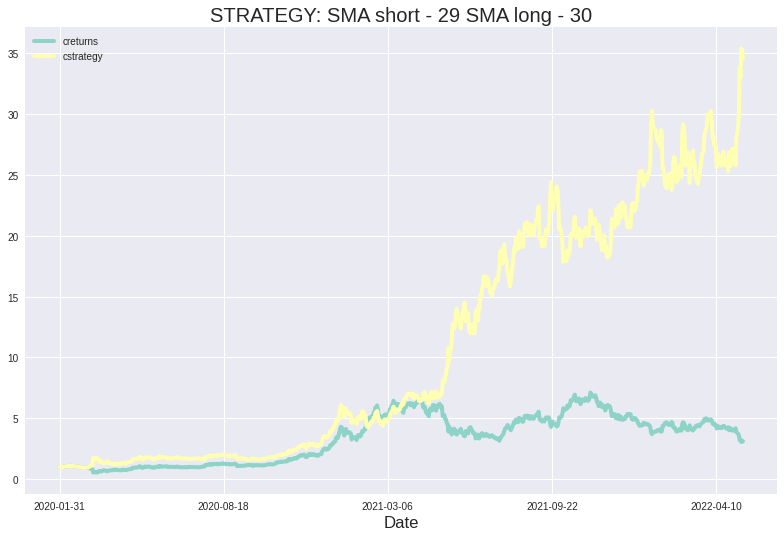

In [ ]:
#plt.style.use('seaborn')
#plt.style.use('dark_background')
#plt.style.use('fivethirtyeight')
#plt.style.use('seaborn-dark-palette')
#plt.style.use('seaborn-dark')
plt.style.use('seaborn-darkgrid')
tester_sma.plot_sma_strategy()

In [ ]:
tester_sma.strategy_metrics

{'cumulative returns': 72.46991200000002,
 'cumulative strategy': 2941.586112,
 'long sma window': 4,
 'short sma window': 1,
 'strategy performance': 2869.1162}

## DEV Tests SMA BackTesting Class

In [ ]:
#tester_sma = SMA_Strategy_Tester(50, 200, '2020-01-01', '2021-05-10')
tester_sma = SMA_Strategy_Tester(50, 200)

tester_sma.load_dataframe(df, normalize=False)

tester_sma.set_sma_params(5,10)

tester_sma.sma_features()

tester_sma.df_window.head()

In [ ]:
tester_sma.test_sma_strategy()

(33.864865, -39.40765)

In [ ]:
tester_sma.results_sma

,price,returns,sma_s,sma_l,positions,strategy,creturns,cstrategy
Date,,,,,,,,
2014-09-21,398.821014,-0.024968,398.821014,406.740250,-1,0.024968,0.975341,1.025282
2014-09-22,402.152008,0.008317,402.152008,401.168251,1,-0.008317,0.983488,1.016790
2014-09-23,435.790985,0.080333,435.790985,411.417000,1,0.080333,1.065754,1.101841
2014-09-24,423.204987,-0.029306,423.204987,414.992249,1,-0.029306,1.034974,1.070019
2014-09-25,411.574005,-0.027868,411.574005,418.180496,-1,-0.027868,1.006530,1.040612
...,...,...,...,...,...,...,...,...
2022-05-09,30296.953125,-0.117055,30296.953125,33974.773438,-1,0.117055,74.093073,2877.144645
2022-05-10,31022.906250,0.023679,31022.906250,32720.269531,-1,-0.023679,75.868436,2809.817873
2022-05-11,28936.355469,-0.069627,28936.355469,31078.870117,-1,0.069627,70.765647,3012.429002


In [ ]:
tester_sma.optimize_sma_strategy_params((1,10,1), (2,20,1))

(array([1., 4.]), 2941.586112)

In [ ]:
tester_sma.strategy_metrics

{'cumulative_returns': 72.46991200000002,
 'cumulative_strategy': 2941.586112,
 'long_sma_window': 4.0,
 'short_sma_window': 1.0,
 'strategy_performance': 2869.1162}

In [ ]:
# TODO !!!

## SEARCHING OPTIMAL HYPERPARAMETERS FOR TRADING STARTEGIES
brute(sma_strategy, ((1, 50, 1), (2, 60, 1)))

# EMA STARTEGY BackTesting Class

In [ ]:
# TODO !!!
# STRATEGY BACKTESTING CLASSES

# TODO
class EMA_Strategy_Tester:
    # TODO
    '''
    Class for vectorized back testing Exponential Moving Average (EMA) trading strategy.

    Attributes:
    ===========
    EMA_short (int): Time window for short EMA.
     EMA_long (int): Time window for loang EMA.
        start (str): Starting date-time.
          end (str): Ending date-time.

    Methods:
    ========
    load_dataframe:
        Load and prepare DataFrame for selected time window.
    sma_features:
        Create EMA data features and add them into DataFrame time window.
    set_sma_params:
        Set new parameters for EMA rolling windows.
    test_sma_strategy:
        Tests the strategy for selected EMA rolling windows.
    update_sma_params_and_run_strategy:
        Update EMA rolling windows values and tests trading strategy.
    optimize_sma_strategy_params:
        Search optimal EMA strategy values for a rolling window.
    plot_sma_strategy:
        Plot strategy resaults.
    '''
    def __init__(self, EMA_short=None, EMA_long=None, date_start=None, date_end=None):
        self.df = None
        self.df_window = None
        self.EMA_s = EMA_short
        self.EMA_l = EMA_long
        self.start = date_start
        self.end = date_end
        self.strategy_metrics = {}
    
    def __repr__(self):
        report = "SMA_BackTester(EMA_short: {}, EMA_long: {}, StartDate: {}, EndDate: {})"
        return report.format(self.EMA_s, self.EMA_l, self.start, self.end)
    
    # TODO
    def load_dataframe(self, df, col_name='Close', normalize=False):
        '''
        Load and prepare DataFrame for selected time window.

        Argumnets:
        ==========
                 df (pandas.DataFrame): Financial dataset.
              col_name (str, optional): Price column name. Default to "Close"
            normalize (bool, optional): Normalize prices in "col_name" column. Default to "False"

        Returns: Not return anything.
        ========
        '''
        data = df[['Date', col_name]].copy()
        data.set_index('Date', inplace=True)
        if self.start == None:
            data_window = data
        else:
            data_window = data.loc[self.start:self.end, :]
        
        self.df_window = data_window.copy()
        self.df_window.rename(columns={col_name: 'price'}, inplace=True)

        if normalize:
            self.df_window['price'] = self.df_window.price / self.df_window.price[0]

    # TODO
    def ema_features(self):
        '''
        Create EMA data features and add them into DataFrame time window.

        Argumnets: No argumnets.
        ==========

        Returns: Not return anything. Updates DataFrame time window variable.
        ========
        '''
        df_temp = self.df_window.copy()
        df_temp['returns'] = np.log(df_temp.price / df_temp.price.shift(1))
        df_temp['ema_s'] = df_temp.price.ewm(span=self.EMA_s, min_periods=self.EMA_s).mean()
        df_temp['ema_l'] = df_temp.price.ewm(span=self.EMA_l, min_periods=self.EMA_l).mean()

        self.df_window = df_temp

    # TODO
    def set_ema_params(self, EMA_short=None, EMA_long=None):
        '''
        Set new parameters for EMA rolling windows.
        
        Argumnets:
        ==========
            EMA_short (int, optional): Short EMA window size. Default to "None"
             EMA_long (int, optional): Short EMA window size. Default to "None"

        Returns: Not return anything. Updates EMA time windows parameters.
        ========
        '''
        if EMA_short is not None:
            self.EMA_s = EMA_short
        if EMA_long is not None:
            self.EMA_l = EMA_long

    # TODO
    def test_ema_strategy(self):
        '''
        Tests the strategy for selected EMA rolling windows.
        
        Argumnets: No argumnets.
        ==========

        Returns:
        ========
            strategy_performance (float): Strategy cumulative sum score.
             returns_performance (float): Strategy cumulative score minus returns cumulative score.
        '''
        df_temp = self.df_window.copy()
        df_temp.dropna(inplace=True)
        
        df_temp['positions'] = np.where(df_temp.ema_s > df_temp.ema_l, 1, -1)
        df_temp['strategy'] = df_temp.positions.shift(1) * df_temp.returns
        df_temp.dropna(inplace=True)
        
        df_temp['creturns'] = df_temp.returns.cumsum().apply(np.exp)
        df_temp['cstrategy'] = df_temp.strategy.cumsum().apply(np.exp)
        
        self.results_ema = df_temp

        strategy_performance = df_temp.cstrategy.iloc[-1]
        returns_performance = strategy_performance - df_temp.creturns.iloc[-1]
        
        return round(strategy_performance, 6), round(returns_performance, 6)
    
    # TODO
    def update_ema_params_and_run_strategy(self, ema_params):
        '''
        Update EMA rolling windows values and tests trading strategy.
        
        Argumnets:
        ==========
            sma_params (tuple): Tuple with EMA windows values.

        Returns:
        ========
            (float): Strategy score.
        '''
        self.set_ema_params(int(ema_params[0]), int(ema_params[1]))
        self.ema_features()
        metrics = self.test_ema_strategy()
        
        self.strategy_metrics['short ema window'] = ema_params[0]
        self.strategy_metrics['long ema window'] = ema_params[1]
        self.strategy_metrics['cumulative returns'] = metrics[0] - metrics[1]
        self.strategy_metrics['cumulative strategy'] = metrics[0]
        self.strategy_metrics['strategy performance'] = metrics[1]
        
        return -self.test_ema_strategy()[0]

    # TODO
    def optimize_ema_strategy_params(self, short_ema_range, long_ema_range):
        '''
        Search optimal EMA strategy values for a rolling window.
        Display optimal EMA window sizes.
        
        Argumnets:
        ==========
            short_ema_range (tuple): 
             long_ema_range (tuple):
        
        Returns:
        ========
            self.results_ema (pandas.DataFrame): Ready EMA Strategy DataFrame with optimal sizes of EMA window.
        '''
        ema_params_optimized = brute(self.update_ema_params_and_run_strategy, (short_ema_range, long_ema_range), finish=None)

        self.set_ema_params(int(ema_params_optimized[0]), int(ema_params_optimized[1]))
        self.ema_features()
        metrics = self.test_ema_strategy()
        strategy_score = self.update_ema_params_and_run_strategy((int(ema_params_optimized[0]), int(ema_params_optimized[1])))
         
        best_values = list(self.strategy_metrics.values())
        
        print('THE BEST EMA PARAMETERS: ')
        print(' best short ema window size: ', best_values[0])
        print(' best long ema window size: ', best_values[1])
        print(' cumulative returns: ', best_values[2])
        print(' cumulative strategy: ', best_values[3])
        print(' strategy performance: ', best_values[4])
        print()
        
        return self.results_ema
        #return sma_params_optimized, -self.update_sma_params_and_run_strategy(sma_params_optimized)
    
    # TODO
    def plot_ema_strategy(self):
        '''
        Plot strategy resaults.
        
        Argumnets: No argumnets.
        ==========

        Returns: Not return anything.
        ========
        '''
        plt.style.use('seaborn-darkgrid')
        title = f'STRATEGY: EMA short - {self.EMA_s} EMA long - {self.EMA_l}'
        self.results_ema[['creturns', 'cstrategy']].plot(title=title, figsize=(12,8));

In [ ]:
SHORT_EMA_RANGE = (1, 50)
LONG_EMA_RANGE = (2, 200)

START_DATE = '2020-01-01'
END_DATE = '2022-05-13'

tester_ema = EMA_Strategy_Tester(date_start=START_DATE, date_end=END_DATE)
#tester_sma = SMA_Strategy_Tester()
tester_ema.load_dataframe(df, normalize=False)
tester_ema.optimize_ema_strategy_params((SHORT_EMA_RANGE[0], SHORT_EMA_RANGE[1], 1), (LONG_EMA_RANGE[0], LONG_EMA_RANGE[1], 1))

THE BEST EMA PARAMETERS: 
 best short ema window size:  12
 best long ema window size:  16
 cumulative returns:  3.396832
 cumulative strategy:  17.226754
 strategy performance:  13.829922



,price,returns,ema_s,ema_l,positions,strategy,creturns,cstrategy
Date,,,,,,,,
2020-01-17,8929.038086,0.023255,8404.565287,8318.980875,1,0.023255,1.023528,1.023528
2020-01-18,8942.808594,0.001541,8491.678943,8400.990809,1,0.001541,1.025106,1.025106
2020-01-19,8706.245117,-0.026809,8526.130392,8440.573445,1,-0.026809,0.997989,0.997989
2020-01-20,8657.642578,-0.005598,8547.105527,8468.386595,1,-0.005598,0.992418,0.992418
2020-01-21,8745.894531,0.010142,8578.632777,8503.574902,1,0.010142,1.002534,1.002534
...,...,...,...,...,...,...,...,...
2022-05-09,30296.953125,-0.117055,36199.172967,36924.350175,-1,0.117055,3.472913,16.849367
2022-05-10,31022.906250,0.023679,35402.824242,36230.062654,-1,-0.023679,3.556129,16.455082
2022-05-11,28936.355469,-0.069627,34407.982892,35371.979456,-1,0.069627,3.316949,17.641630


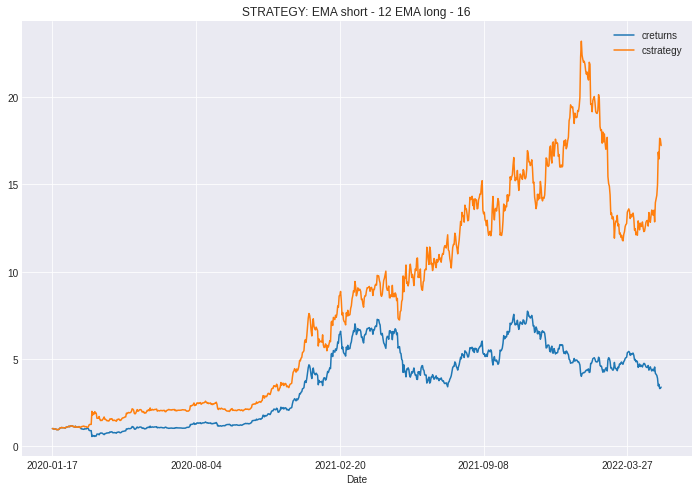

In [ ]:
tester_ema.plot_ema_strategy()

# SINGLE TECHNICAL INDICATOR FUNCTIONS

In [ ]:
# TODO !!!

# TECHNICAL INDICATORS FUNCTIONS

################################################################################
# SIMPLE TECHNICAL INDICATORS

def add_price_diff(col_name='close'):
    '''
    Price difference between the previous value and the next value.

    Parameters:
      col_name (str, optional): Price column name. Defaults to "close". 
    
    Returns:
      series_diff (pandas.series): Series with price difference.
    '''
    df['diff'] = df[col_name] - df[col_name].shift(1)
    
    #series_diff = df[col_name] - df[col_name].shift(1)
    #return series_diff

def add_diff_percentage(col_name='close'):
    '''
    Percentage price difference between the previous value and the next value.

    Parameters:
      col_name (str, optional): Price column name. Defaults to "close". 
    
    Returns:
      series_diff (pandas.series): Series with percentage price difference.
    '''
    df['diff_%'] = (df[col_name] - df[col_name].shift(1)) / df[col_name].shift(1)
    
    #df_diff_percentage = (df[col_name] - df[col_name].shift(1)) / df[col_name].shift(1)
    #return df_diff_percentage

def add_diff_percentage_round(col_name='close', val_round=1):
    '''
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    df['diff_%_round'] = round((df[col_name] - df[col_name].shift(1)) / df[col_name].shift(1) * 100, val_round)

    #df_diff_percentage_round = round((df[col_name] - df[col_name].shift(1)) / df[col_name].shift(1) * 100, val_round)
    #return df_diff_percentage_round
    
def add_diff_percentage_bin(col_name='close'):
    '''
    Rounded to int value, percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
    
    Returns:
      series_diff (pandas.series): Series with rounded to int percentage price difference.
    '''
    #self.df.dropna(inplace=True)
    df['diff_%_bin'] = round((df[col_name] - df[col_name].shift(1)) / df[col_name].shift(1) * 100)

    #df_diff_percentage_bin = round((df[col_name] - df[col_name].shift(1)) / df[col_name].shift(1) * 100)
    #return df_diff_percentage_bin

################################################################################
# FINNACIAL RETURNS FUNCTIONS

# TODO
def add_returns(col_name='close'):
    '''
    TODO
    Create new columns - logarithimc returns.
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    #self.df.dropna(inplace=True)
    #self.df.reset_index(drop=True, inplace=True)
    df['returns'] = np.log(df[col_name].div(df[col_name].shift(1)))

# TODO
def add_returns_cumsum(col_name='close'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    returns = np.log(df[col_name].div(df[col_name].shift(1)))    
    df['creturns'] = returns.cumsum().apply(np.exp)   

# TODO
def add_returns_cummax(col_name='close'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    returns = np.log(df[col_name].div(df[col_name].shift(1)))    
    df['returns_cummax'] = returns.cummax().apply(np.exp)

# TODO
def add_return_drowdown(col_name='close'):
    '''
    TODO
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    returns = np.log(df[col_name].div(df[col_name].shift(1)))
    cum_max = returns.cummax().apply(np.exp)    
    df['drow_down'] = cum_max - returns

################################################################################
# MOVING AVERAGES INDICATORS

# TODO
def add_sma(window_size=12, col_name='close'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    df['sma_'+str(window_size)] = df[col_name].rolling(window=window_size).mean()

# TODO
def add_ema(window_size=12, col_name='close'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    df['ema'+str(window_size)] = df[col_name].ewm(span=window_size, peroids=window_size).mean()

# TODO
def add_macd(signal_window_size=12, short_ema_window_size=1, long_ema_window_size=2):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''    
    pass

# TODO
def add_rsi(sma_window_size=12, col_name='close'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    df_temp = df.copy()
    df_temp['diff'] = df_temp[col_name] - df_temp[col_name].shift(1)
    df_temp['UP'] = np.where(df_temp.diff > 0, df_temp.diff, 0)
    df_temp['DOWN'] = np.where(df_temp.diff < 0, -df_temp.diff, 0)
    
    df_temp['SMA_UP'] = df_temp.UP.rolling(window=sma_window_size).mean()
    df_temp['SMA_DOWN'] = df_temp.DOWN.rolling(window=sma_window_size).mean()
    
    df['RSI'] = df_temp.SMA_UP / (df_temp.SMA_UP + df_temp.SMA_DOWN) * 100

################################################################################
# POSITIONS and STARTEGIES

# TODO
def add_short_long_sma_strategy(short_sma_window=7, long_sma_window=30, col_name='close'): # STRATEGY POSITION
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    short_sma = df[col_name].rolling(window=short_sma_window).mean()
    long_sma = df[col_name].rolling(window=long_sma_window).mean()
    returns = np.log(df[col_name].div(df[col_name].shift(1)))
    
    position = np.where(short_sma > long_sma, 1, -1)
    strategy = position.shift(1) * returns
    strategy_cumsum = strategy.cumsum().apply(np.exp)
    
    df[f'position_sma_{str(short_sma_window)}-{str(long_sma_window)}'] = position
    df[f'strategy_sma_{str(short_sma_window)}-{str(long_sma_window)}'] = strategy
    df[f'strategy_sma_cumsum_{str(short_sma_window)}-{str(long_sma_window)}'] = strategy_cumsum

# TODO
def add_short_long_ema_strategy(short_ema_window=7, long_ema_window=30, col_name='close'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    short_ema = df[col_name].ewm(span=short_ema_window, peroids=short_ema_window).mean()
    long_ema = df[col_name].ewm(span=long_ema_window, peroids=long_ema_window).mean()
    returns = np.log(df[col_name].div(df[col_name].shift(1)))
    
    position = np.where(short_ema > long_ema, 1, -1)
    strategy = position.shift(1) * returns
    strategy_cumsum = strategy.cumsum().apply(np.exp)
    
    df[f'position_ema_{str(short_ema_window)}-{str(long_ema_window)}'] = position
    df[f'strategy_ema_{str(short_ema_window)}-{str(long_ema_window)}'] = strategy
    df[f'cum_strategy_ema_{str(short_ema_window)}-{str(long_ema_window)}'] = strategy_cumsum

# TODO
def add_cross_sma_ema_strategy(window_size=12, col_name='close'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    sma = df[col_name].rolling(window=window_size).mean()
    ema = df[col_name].ewm(span=window_size, peroids=window_size).mean()
    returns = np.log(df[col_name].div(df[col_name].shift(1)))

    position = np.where(ema > sma, 1, -1)
    strategy = position.shift(1) * returns
    strategy_cumsum = strategy.cumsum().apply(np.exp)
    
    df[f'position_cross_smaema_w{str(window_size)}'] = position
    df[f'strategy_cross_smaema_w{str(window_size)}'] = strategy
    df[f'cum_strategy_cross_smaema_w{str(window_size)}'] = strategy_cumsum

# TODO
def add_macd_strategy(short_ema_window=7, long_ema_window=30, macd_signal_window=9, col_name='close'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    short_ema = df[col_name].ewm(span=short_ema_window, peroids=short_ema_window).mean()
    long_ema = df[col_name].ewm(span=long_ema_window, peroids=long_ema_window).mean()
    returns = np.log(df[col_name].div(df[col_name].shift(1)))

    df[f'MACD_s{short_ema_window}-l{long_ema_window}'] = ema_short - ema_long
    df[f'MACD_signal_{macd_signal_window}'] = df[f'MACD_s{short_ema_window}-l{long_ema_window}'].ewm(span=macd_signal_window, min_periods=macd_signal_window).mean()
    df.dropna(inplace=True)

    df[f'positions_MACD_s{short_ema_window}_l{long_ema_window}_w{macd_signal_window}'] = np.where((df[f'MACD_s{short_ema_window}-l{long_ema_window}'] - df[f'MACD_signal_{macd_signal_window}']) > 0, 1, -1)
    df[f'strategy_MACD_s{short_ema_window}_l{long_ema_window}_w{macd_signal_window}'] = df[f'positions_MACD_s{short_ema_window}_l{long_ema_window}_w{macd_signal_window}'].shift(1) * returns
    df[f'cum_strategy_MACD_s{short_ema_window}_l{long_ema_window}_w{macd_signal_window}'] = df[f'strategy_MACD_s{short_ema_window}_l{long_ema_window}_w{macd_signal_window}'].cumsum().apply(np.exp)
    df.dropna(inplace=True)

# TODO
def add_rsi_strategy():
    '''
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    pass

# TODO
def add_macd_rsi_strategy():
    '''
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    pass

# TODO
def add_stochastic_oscilator_strategy():
    '''
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    pass

# TODO
def add_fibonacci_retracement_strategy():
    '''
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    pass

In [ ]:
# TODO !!!

# APPLY TECHNICAL INDICATORS
def add_all_indicators_train():
    '''
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    add_diff_percentage()
    add_difference()
    add_diff_percentage()
    add_diff_percentage_round()
    add_diff_percentage_bin()
    add_returns()
    add_returns_cumsum()

    # DEV testing
    # drop first row "NaN" afetr transformation above
    df.dropna(inplace=True)
    # convert to int
    df['diff_%_bin'] = df['diff_%_bin'].astype(int)

    # create a lot of "NaN"
    add_sma()
    add_short_long_sma_positions()

################################################################################
all_indicators()
df.head(3)

# LABELS GENERATORS FUNCTIONS 

In [ ]:
# TODO !!!

# LABELS CREATOR FUNCTIONS

# TODO
def train_labels_creator_UP_ZERO_DOWN(col_name='close', tresh_hold=0.3):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    actual_value = df[col_name]
    next_value = df[col_name].shift(-1)
    percentage_value_change = round((next_value - actual_value) / actual_value, 1)
        
    set_ones = np.where(percentage_value_change >= tresh_hold, 1, percentage_value_change)
    set_m_ones = np.where(set_ones <= -tresh_hold, -1, set_ones)
    up_zero_down = np.where((set_m_ones != -1) & (set_m_ones != 1), 0, set_m_ones)
        
    df[f'y_next_val_{str(tresh_hold)}'] = up_zero_down

# TODO
def train_labels_creator_RANGED_MEAN(col_name='close', window_size=7):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    actual_value = df[col_name]
    next_value = df[col_name].shift(-window_size)
    percentage_value_change = (next_value - actual_value) / actual_value 
    next_mean = percentage_value_change.rolling(window=window_size).mean()

    df[f'y_next_mean_{str(window_size)}'] = round(next_mean*100, 1)

# TODO
def add_all_LABELS_TRAIN():
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    train_labels_creator_UP_ZERO_DOWN()
    train_labels_creator_RANGED_MEAN()

# FINANCIAL TIME SERIES ANALYSIS TOOLS

In [ ]:
# TODO !!!

# PRICE TIME SERIES ANALYSIS

# TODO
def count_range_probability_distribution(window_size=7, min_max=10, col_name='diff_%_bin'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    lenbin = len(range(-min_max, min_max+1, 1))
    count_dict = {bin: val for bin, val in zip(range(-min_max, min_max+1, 1), np.zeros(lenbin))}
    probs_dict = {bin: val for bin, val in zip(range(-min_max, min_max+1, 1), np.zeros(lenbin))}
    #print(count_dict)

    values = df[col_name].value_counts()
    sum_values = sum(values)

    for idx, val in zip(values.index, values):
        probs = round(val / sum_values, 3)
        if idx in list(count_dict.keys()):
            count_dict[idx] = val
            probs_dict[idx] = probs
            
    #print(idx, val, probs)
    return count_dict, probs_dict

# TODO
def data_hist(col_name='diff_%_bin'):
    '''
    TODO
    Rounded percentage price difference between the previous value and the next value.
    
    Parameters:
      col_name (str, optional): Price column name. Defaults to "close".
      val_round (int, optional): Decimal places to round. Defaults to "1".
    
    Returns:
      series_diff (pandas.series): Series with rounded percentage price difference.
    '''
    df[col_name].hist();